In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
from random import sample 
import matplotlib.image as image
import pydicom
from skimage import io

##Import any other packages you may need here

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
47061,00011998_002.png,Infiltration,2,11998,39,F,PA,2992,2991,0.143,0.143,NaN
40124,00010475_026.png,No Finding,26,10475,64,F,AP,2500,2048,0.168,0.168,NaN
37360,00009863_005.png,Infiltration,5,9863,40,F,AP,2500,2048,0.168,0.168,NaN


In [3]:
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
983,00005119_002.png,No Finding,2,5119,021Y,M,PA,2048,2500,0.171000,0.171000
4029,00019860_000.png,No Finding,0,19860,054Y,M,PA,2992,2991,0.143000,0.143000
5576,00030439_006.png,No Finding,6,30439,056Y,F,PA,2021,2021,0.194311,0.194311


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do.

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc.

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia.

Perform the following EDA:
- The patient demographic data such as gender, age, patient position,etc. (as it is available)
- The x-ray views taken (i.e. view position)
- The number of cases including:
    - number of pneumonia cases, 
    - number of non-pneumonia cases
- The distribution of other diseases that are comorbid with pneumonia
- Number of disease per patient
- Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use sample_labels.csv for the pixel-level assassements.

Also, describe your findings and how will you set up the model training based on the findings.

In [4]:
# First I want to separate the findings labels into separate columns
all_xray_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_xray_labels = [x for x in all_xray_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_xray_labels), all_xray_labels))
for c_label in all_xray_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
102434,00027294_001.png,No Finding,1,27294,61,F,PA,2534,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74140,00018233_008.png,Cardiomegaly,8,18233,47,F,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32537,00008510_000.png,Effusion|Mass|Pleural_Thickening,0,8510,55,F,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


Min Age:  1
Max Age:  414


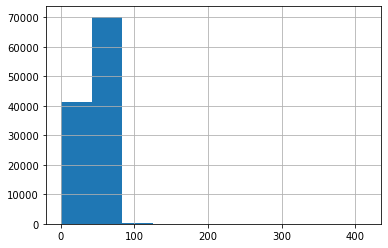

In [5]:
# Age
all_xray_df['Patient Age'].hist()
print('Min Age: ',all_xray_df['Patient Age'].min())
print('Max Age: ',all_xray_df['Patient Age'].max())

The above graph is showing that there are people way over the age of 100 which doesnt seem realistic. Need to take a closer look. 

In [6]:
above_100 = all_xray_df[all_xray_df['Patient Age'] > 100]
above_100

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


All of these are well over 100 and not likely real. I will remove them from the dataset

Min Age:  1
Max Age:  95


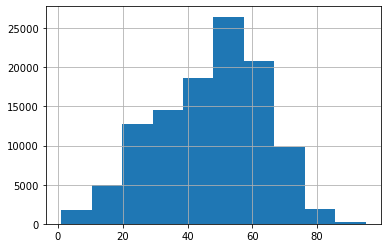

In [7]:
all_xray_df = all_xray_df[all_xray_df['Patient Age']<=100]
all_xray_df['Patient Age'].hist()
print('Min Age: ', all_xray_df['Patient Age'].min())
print('Max Age: ', all_xray_df['Patient Age'].max())

The new distribution with outliers removed. Much more realistic. Slightly skewed right (center ~58 not 50). Overall, relatively normal.

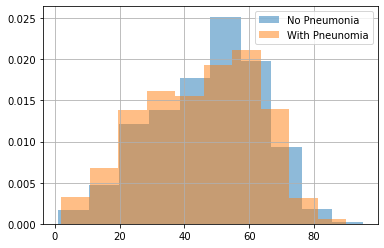

In [8]:
# Look at prevelence of pneumonia in cases with at least 1 finding
#all_xray_df.groupby(['Pneumonia'])['Patient Age'].hist()
#plt.legend(['+Pneumonia', '-Pneunomia'])
all_xray_df.groupby(['Pneumonia'])['Patient Age'].hist(density=True, alpha=0.5)
plt.legend(['No Pneumonia', 'With Pneunomia'])

The age distribution in patients with pneumonia and without are roughly the same, and both a fairly normal distribution

There are 48776 ( 43.5095982302148 %)females and 63328 ( 56.4904017697852 %) males in the dataset


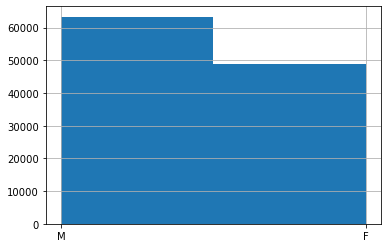

In [9]:
## EDA
# Gender 
males = len(all_xray_df[all_xray_df['Patient Gender'] == 'M'])
females = len(all_xray_df[all_xray_df['Patient Gender'] == 'F'])
perc_f = 100*(females/(males+females))
perc_m = 100*(males/(males+females))
print('There are',females,'(',perc_f,'%)females and',males,'(',perc_m,'%) males in the dataset')
all_xray_df['Patient Gender'].hist(bins=2)

In [25]:
# Look at prevelence of pneumonia in cases with at least 1 finding
#all_xray_df.groupby(['Pneumonia'])['Patient Age'].hist()
#plt.legend(['+Pneumonia', '-Pneunomia'])
pp_male = len(all_xray_df[all_xray_df['Pneumonia']==1][all_xray_df['Patient Gender']=='M'])
pn_male = len(all_xray_df[all_xray_df['Pneumonia']==0][all_xray_df['Patient Gender']=='M'])
pp_fmale = len(all_xray_df[all_xray_df['Pneumonia']==1][all_xray_df['Patient Gender']=='F'])
pn_fmale = len(all_xray_df[all_xray_df['Pneumonia']==0][all_xray_df['Patient Gender']=='F'])
f_perc = 100*(pp_fmale/(pp_fmale+pn_fmale))
m_perc = 100*(pp_male/(pp_male+pn_male))
print(f'{f_perc}% of females and {m_perc}% of males in the dataset have pneumonia')

41.46853146853147 58.53146853146853
1.2157618500902083% of females and 1.3216902475997978% of males in the dataset have pneumonia


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


Of the patients with pneumonia, 41.46853146853147% are female and 58.53146853146853% are male


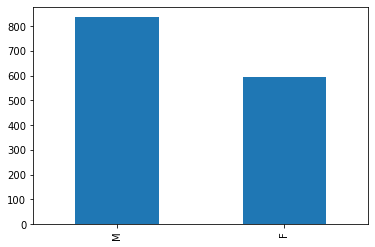

In [28]:
# Addressing note from review 1: Include gender distribution for pneumonia cases
f_perc2 = 100*(pp_fmale/(pp_fmale+pp_male))
m_perc2 = 100*(pp_male/(pp_fmale+pp_male))
print(f'Of the patients with pneumonia, {f_perc2}% are female and {m_perc2}% are male')
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')


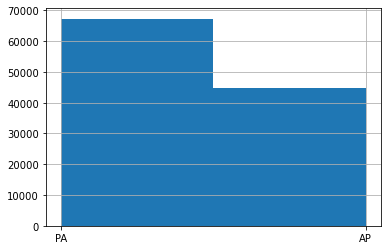

In [53]:
# View Position
all_xray_df['View Position'].hist(bins=2)

In [54]:
n_PA = len(all_xray_df[all_xray_df['View Position']=='PA'])
n_AP = len(all_xray_df[all_xray_df['View Position']=='AP'])
p_PA = 100*(n_PA/(n_PA+n_AP))
p_AP = 100*(n_AP/(n_PA+n_AP))
print('There are',n_PA,'(',p_PA,'%) images in the PA position and',n_AP,'(',p_AP,'%) images in the AP position')

There are 67299 ( 60.03264825519161 %) images in the PA position and 44805 ( 39.9673517448084 %) images in the AP position


There are 1430 ( 1.2756012274316706 %) positive cases of Pneumonia and 110674 ( 98.72439877256834 %) negative cases for Penumonia in the data set


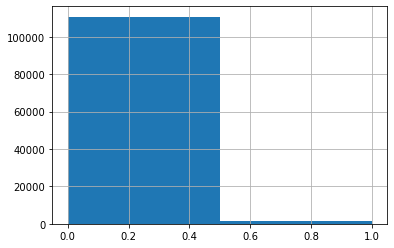

In [55]:
# Case numbers (pneumonia v not)
p_pos = len(all_xray_df[all_xray_df['Pneumonia']==1])
p_neg = len(all_xray_df[all_xray_df['Pneumonia']==0])
pos_perc = 100*(p_pos/(p_pos+p_neg))
neg_perc = 100*(p_neg/(p_pos+p_neg))
print('There are',p_pos,'(',pos_perc,'%) positive cases of Pneumonia and',p_neg,'(',neg_perc,'%) negative cases for Penumonia in the data set')
all_xray_df['Pneumonia'].hist(bins=2)

There are 1430 ( 2.763231628374331 %) positive cases of Pneumonia and 50321 ( 97.23676837162567 %) negative cases for in the subset of patients with at least 1 finding


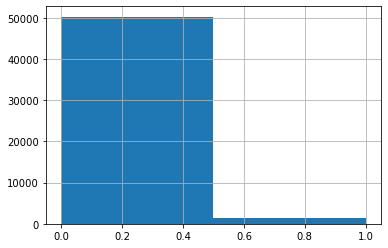

In [56]:
only_findings_df = all_xray_df[all_xray_df['No Finding']==0]
p_pos2 = len(only_findings_df[only_findings_df['Pneumonia']==1])
p_neg2 = len(only_findings_df[only_findings_df['Pneumonia']==0])
pos_perc2 = 100*(p_pos2/(p_pos2+p_neg2))
neg_perc2 = 100*(p_neg2/(p_pos2+p_neg2))
print('There are',p_pos2,'(',pos_perc2,'%) positive cases of Pneumonia and',p_neg2,'(',neg_perc2,'%) negative cases for in the subset of patients with at least 1 finding')
only_findings_df['Pneumonia'].hist(bins=2)

According to the directions above, this is not an accurate representation of pneumonia in "the wild" so 20% wil be the assumed rate in the validatoin set

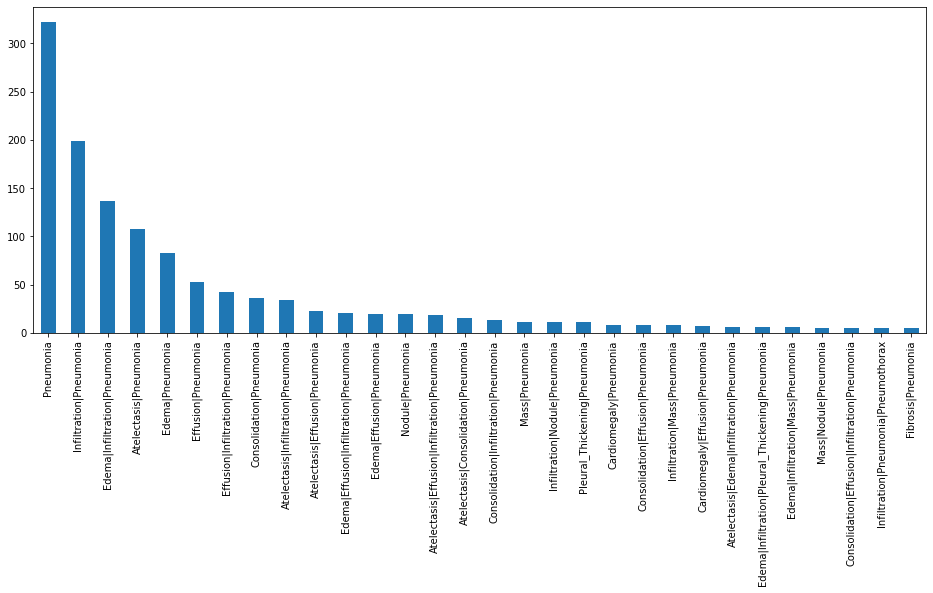

In [57]:
# Look at the common comorbidities with pneumonia
plt.figure(figsize=(16,6))
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:30].plot(kind='bar')

It looks like Pneumonia occurs most often on its own, but common co-morbidities are infiltration and Edema w/Infiltration. 

In [58]:
# Number of diseases per patient
num_diseases = all_xray_df.iloc[:,[12,13,14,15,16,17,18.19,20,21,23,24,25,26]].sum(axis=1)
all_xray_df['Number_of_Diseases'] = num_diseases
all_xray_df.sample(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Number_of_Diseases
75810,00018610_010.png,No Finding,10,18610,64,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
69164,00017064_015.png,Infiltration,15,17064,69,M,AP,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
99399,00026293_000.png,No Finding,0,26293,46,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
10711,00002771_000.png,No Finding,0,2771,73,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
58463,00014455_001.png,No Finding,1,14455,59,M,PA,2570,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1506,00000395_000.png,No Finding,0,395,73,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
80524,00019771_000.png,No Finding,0,19771,70,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
59542,00014710_007.png,Atelectasis,7,14710,59,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
36789,00009689_025.png,No Finding,25,9689,59,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
45008,00011560_000.png,No Finding,0,11560,63,M,PA,2758,2605,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


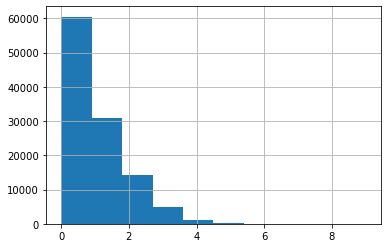

In [59]:
all_xray_df['Number_of_Diseases'].hist()

The majority of people have 0 diseases (this is the percentage that are "No findings"). Aside from those people, most people only have 1 disease.

In [60]:
## Pixel analysis
sample_df.info()
sample_df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  5606 non-null   object 
 1   Finding Labels               5606 non-null   object 
 2   Follow-up #                  5606 non-null   int64  
 3   Patient ID                   5606 non-null   int64  
 4   Patient Age                  5606 non-null   object 
 5   Patient Gender               5606 non-null   object 
 6   View Position                5606 non-null   object 
 7   OriginalImageWidth           5606 non-null   int64  
 8   OriginalImageHeight          5606 non-null   int64  
 9   OriginalImagePixelSpacing_x  5606 non-null   float64
 10  OriginalImagePixelSpacing_y  5606 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.9+ KB


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
833,00004360_010.png,No Finding,10,4360,076Y,M,AP,2500,2048,0.171,0.171
1722,00009024_000.png,No Finding,0,9024,053Y,M,PA,2500,2048,0.168,0.168
421,00002251_003.png,No Finding,3,2251,067Y,F,PA,2048,2500,0.168,0.168
255,00001373_009.png,Cardiomegaly,9,1373,058Y,M,AP,2500,2048,0.168,0.168
1915,00010007_125.png,Effusion|Infiltration,125,10007,058Y,M,AP,2500,2048,0.168,0.168
1757,00009281_014.png,No Finding,14,9281,023Y,F,PA,2684,2920,0.143,0.143
3486,00017151_012.png,Atelectasis|Effusion,12,17151,031Y,M,PA,2992,2991,0.143,0.143
4667,00023325_027.png,No Finding,27,23325,083Y,F,AP,2048,2500,0.168,0.168
2333,00011847_001.png,No Finding,1,11847,065Y,M,PA,2992,2991,0.143,0.143
1343,00007007_001.png,Consolidation,1,7007,045Y,F,AP,2500,2048,0.171,0.171


In [61]:
# First I want to separate the findings labels into separate columns
all_sample_labels = np.unique(list(chain(*sample_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_sample_labels = [x for x in all_sample_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_sample_labels), all_sample_labels))
for c_label in all_sample_labels:
    if len(c_label)>1: # leave out empty labels
        sample_df[c_label] = sample_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
sample_df.sample(3)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
1269,00006681_000.png,No Finding,0,6681,048Y,F,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4903,00025839_019.png,Effusion,19,25839,029Y,M,AP,2765,2433,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4682,00023651_000.png,No Finding,0,23651,061Y,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [62]:
!ls /data/

ARXIV_V5_CHESTXRAY.pdf	images_002  images_007	images_012
BBox_List_2017.csv	images_003  images_008	LOG_CHESTXRAY.pdf
Data_Entry_2017.csv	images_004  images_009	README_CHESTXRAY.pdf
FAQ_CHESTXRAY.pdf	images_005  images_010	test_list.txt
images_001		images_006  images_011	train_val_list.txt


In [63]:
def find_image_path(row):
    img_path = None
    f = row['Image Index']
    for d in range(12):
        possible_paths = ['images_001', 'images_002', 'images_003', 'images_004', 'images_005', 'images_006',
                         'images_007', 'images_008', 'images_009', 'images_010', 'images_011', 'images_012']
        test = '/data/' + possible_paths[d] + '/images/' + f
        if os.path.isfile(test):
            img_path = test
        else: continue
    return img_path

sample_df['image_path'] = sample_df.apply(find_image_path, axis=1)
sample_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,image_path
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,/data/images_001/images/00000013_005.png
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000013_026.png
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000017_001.png
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000030_001.png
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_001/images/00000032_001.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5601,00030712_000.png,No Finding,0,30712,058Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_012/images/00030712_000.png
5602,00030786_005.png,Cardiomegaly|Effusion|Emphysema,5,30786,061Y,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_012/images/00030786_005.png
5603,00030789_000.png,Infiltration,0,30789,052Y,F,PA,2021,2021,0.194311,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,/data/images_012/images/00030789_000.png
5604,00030792_000.png,No Finding,0,30792,010Y,F,PA,1775,1712,0.194311,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,/data/images_012/images/00030792_000.png


In [64]:
Findings = set(all_sample_labels)
Findings

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

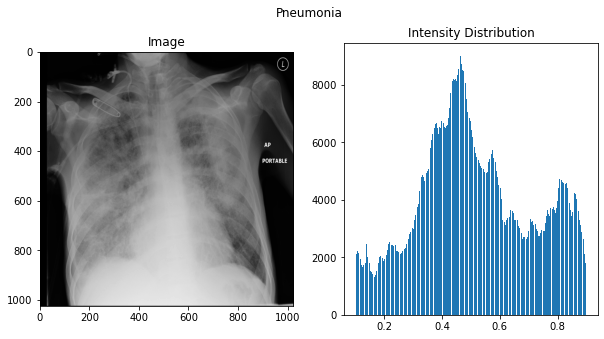

In [65]:
# Pneumonia sample
sample_p = sample_df[sample_df['Pneumonia']==1].sample()
intensities = []
impaths = sample_p.image_path
for path in impaths:
    data = image.imread(path)
    mask = (data > 0.1) & (data < 0.9)
    intensities.extend(data[mask].flatten().tolist())
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
f.suptitle('Pneumonia')
s1 = f.add_subplot(1, 2, 1)
s1.set_title('Image')
plt.imshow(data, cmap='gray')


s2 = f.add_subplot(1, 2, 2)
s2.set_title('Intensity Distribution')
plt.hist(intensities, bins = 256)
    
plt.show()

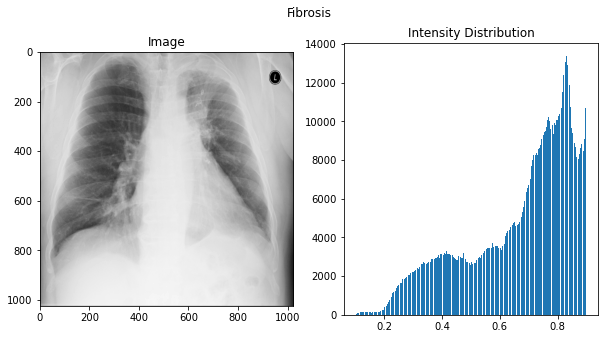

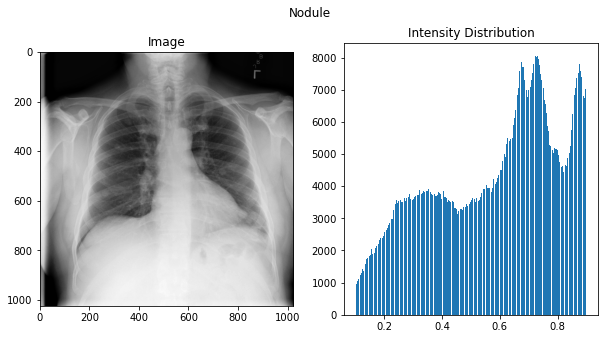

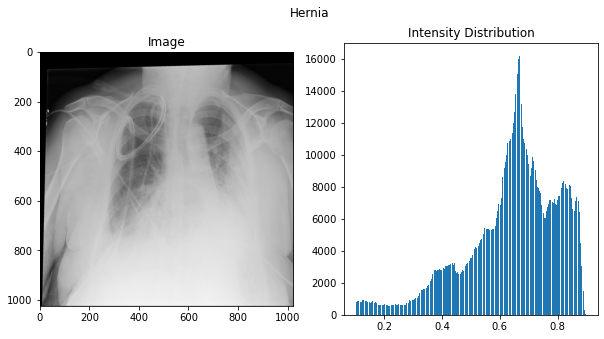

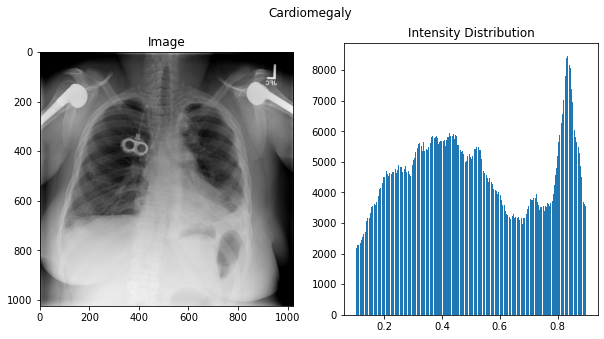

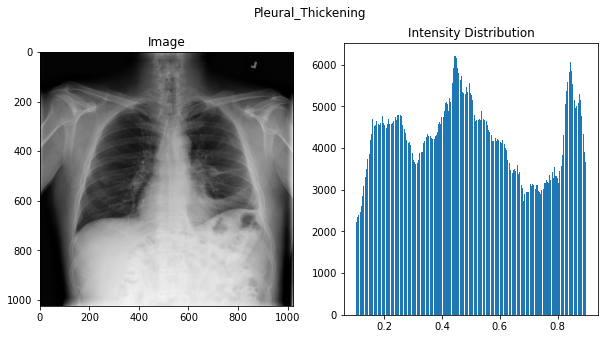

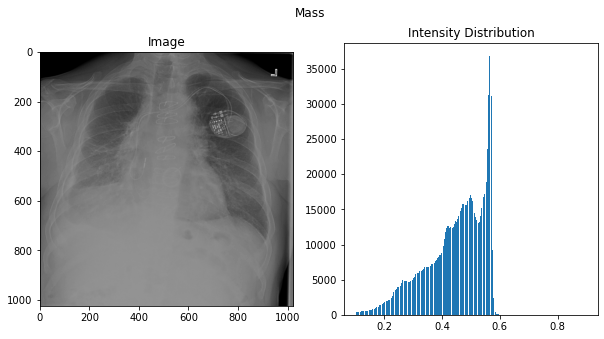

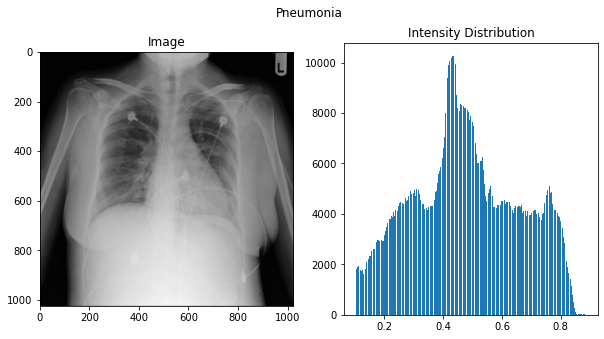

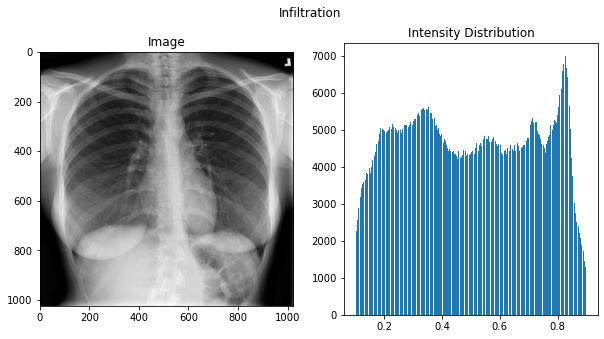

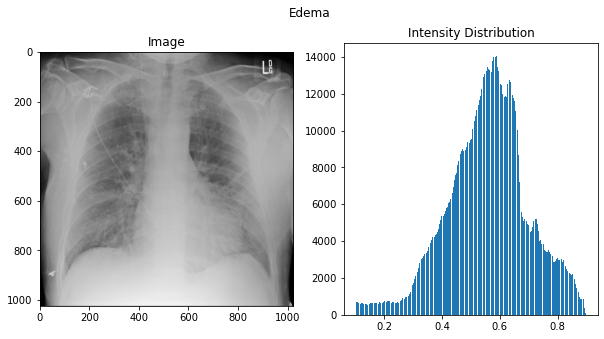

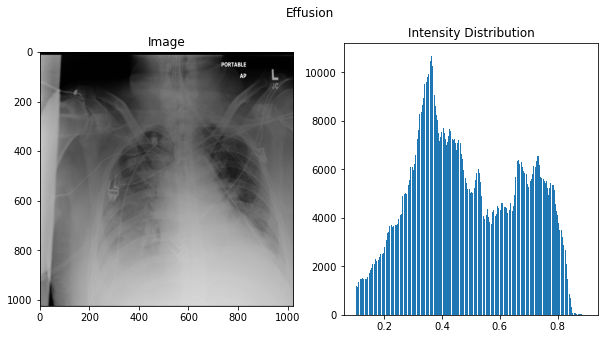

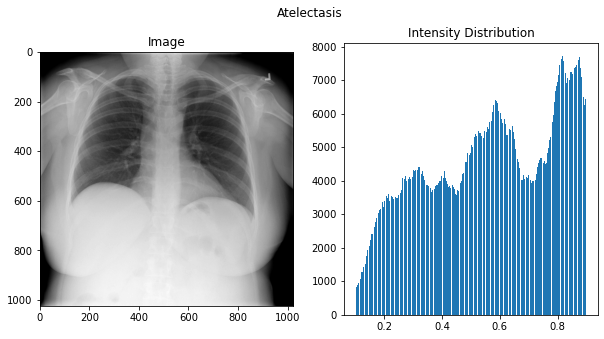

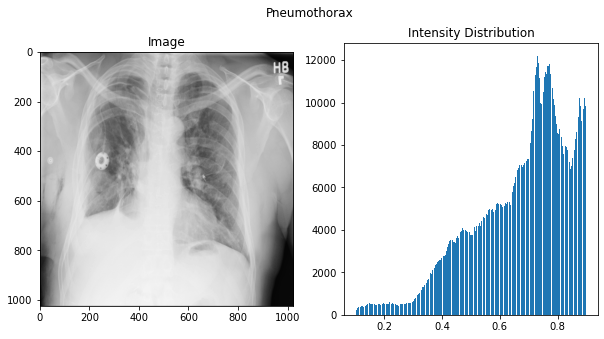

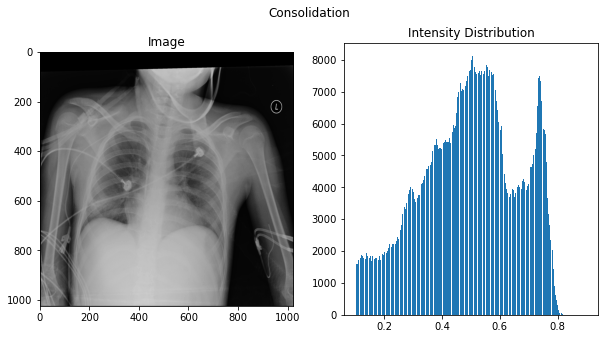

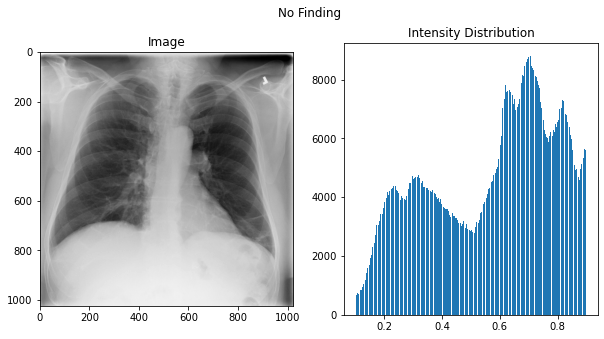

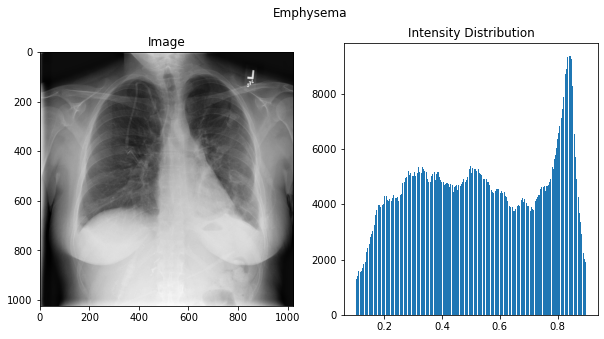

In [66]:
# Plot an image and histogram for a sample from each possible finding
# Loop for each finding
for finding in Findings:
    
    sample_p = sample_df[sample_df[finding]==1].sample()
    intensities = []
    impaths = sample_p.image_path
    for path in impaths:
        data = image.imread(path)
        mask = (data > 0.1) & (data < 0.9)
        intensities.extend(data[mask].flatten().tolist())
    f = plt.figure()
    f.set_figwidth(10)
    f.set_figheight(5)
    f.suptitle(finding)
    s1 = f.add_subplot(1, 2, 1)
    s1.set_title('Image')
    plt.imshow(data, cmap='gray')


    s2 = f.add_subplot(1, 2, 2)
    s2.set_title('Intensity Distribution')
    plt.hist(intensities, bins = 256)
    
    plt.show()

# Summary of findings
## Age
- After discovering the outliers in age (patients well over 100) I decided these had to be errors and removed these cases from the dataset. This step was moved up to be at the top of the analysis so all further analysis would not include the erraneous cases. 
- Overall the distribution of ages (with outliers removed) is fairly normal, spanning from ages 1 to 95. The peak is slightly off center, sitting around 58 instead of closer to 50, but this is still a fairly normal and even distribution. There was a very similar distribution in age between those with and without pneumonia. 
## Gender
- The gender of the patients was split roughly 56% male and 44% female. While the dataset does favor males slightly, there is still adequate representation for male and females to be a part of the groups indicated for use.  
- A very similar percentage of males and females in the data set had pneumonia -- 1.3% and 1.2% respectively
## View Position
- The data set favored the PA position but there are ample amounts of both AP and PA positioned images to qualify each as a indicated position for use. No other positions were present.
## Pneumonia presence
- There are 1430 ( 1.2756012274316706 %) positive cases of Pneumonia and 110674 ( 98.72439877256834 %) negative cases for Penumonia in the data set
- There are 1430 ( 2.763231628374331 %) positive cases of Pneumonia and 50321 ( 97.23676837162567 %) negative cases for in the subset of patients with at least 1 finding
- However, according to the information from the README file, this is not an accurate representation of pneumonia in "the wild" so 20% wil be the assumed rate in the validatoin set
- Common co-morbidities with pneumonia are infiltration and Edema w/Infiltration, however, pneumonia occurs most often on its own. 
- The majority of people have 0 diseases (this is the percentage that are "No findings"). Aside from those people, most people only have 1 disease.
## Pixel Analysis
- for the pixel analysis, a sample of 1 case from each of the findings was presented both as the raw image and a histogram of the intensity values. 
- The sample for "No finding" showed a relatively focused plot with one major peak around 0.6
- The plots for pneumonia, consolidation and infiltration were similar in distribution/shape
- The plots for nodule and atelectasis were similar in distribution/shape
- The plots for emphysema, cardiomegaly, effusion, hernia and edema were similar in distribution/shape
- The plots for pneumothorax and mass were similar in distribution/shape
- The plots for plueral thickening and fibrosis were similar in distribution/shape
